In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

dirs = ['../DataGeneration/Python', './net/']
for d in dirs:
    if d not in sys.path:
        sys.path.append(d)

import Sample
import Dataloader

from Transformer import Transformer

In [37]:
## Boilerplate setup code

DATASET_PATH = '../Dataset/CC10k.npy'
N_WORKERS = 0

# From data
d_input = 4 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10

# Hyperparameters
BATCH_SIZE = 1
D_MODEL = 64
q = 8 
v = 8
h = 8
Ne = 4
Nd = 4
DROPOUT = 0

# Load some of our data
geoData = Dataloader.formattedLoader(d_input, d_output, DATASET_PATH) # Get input data formatted for network
data_train, data_val = random_split(geoData, (9000, 1000))
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

In [3]:
def test(model, loss_function, trainingLoss=False):
    val_loss = []
    train_loss = []

    if trainingLoss:
        for i, (x, y) in enumerate(dataloader_train):        
            # Zero gradients
            x = x.float()
            yhat = model(x)
            loss = loss_function(y, yhat).item()/BATCH_SIZE
            train_loss.append(loss)

    for i, (x, y) in enumerate(dataloader_val):        
        # Zero gradients
        x = x.float()
        yhat = model(x)
        loss = loss_function(y, yhat).item()/BATCH_SIZE
        val_loss.append(loss)
    
    return train_loss, val_loss

# Loads a model checkpoint: 
def loadModel(checkpoint):
    state_dict = torch.load('Checkpoints/'+checkpoint)
    model = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
    model.load_state_dict(state_dict)
    return model



In [6]:
# Compare performance across model checkpoints 
checkpoints = !ls Checkpoints/

model_path = 'Checkpoints/TST.pth' # Change to select which version of trained model to use

criterion = nn.MSELoss()

In [4]:


val_losses = []

for i, checkpoint in enumerate(checkpoints):
    model = loadModel(checkpoint)
    model.eval()
    tl, vl = test(model, criterion)
    val_losses.append(vl)
    

In [5]:
losses = np.array(val_losses)
np.average(losses, axis=1)


array([282.5052016 , 565.99881102, 338.05843297, 346.67657891,
       481.27567864, 291.71557829, 328.95007018, 355.42015801,
       276.58334671, 231.00482618, 222.03101561])

In [6]:

def samps(model):
    yhats = []
    running_loss = []
    for i, (x, y) in enumerate(dataloader_train):        
        # Zero gradients
        x = x.float()
        yhat = model(x)[0]
        yhat = yhat.detach().numpy()
        yhats.append(yhat)
        plt.figure(i)
        plt.plot(range(len(yhat)), yhat)
        plt.plot(range(len(y[0])), y[0])
        if (i==10):
            return yhats
            break
        

In [55]:
def best_of(checkpoint):
    model = loadModel(checkpoint)
    model.eval()
    best_loss = np.Inf
    top_performers = []
    indices = []
    for i, (x, y) in enumerate(dataloader_val):        
            # Zero gradients
            x = x.float()
            yhat = model(x)
            loss = criterion(y, yhat).item()/BATCH_SIZE
            if best_loss > loss:
                best_loss = loss
                top_performers.append((yhat, y))
                indices.append(i)

    for i, samples in enumerate(top_performers):
        plt.figure(i)
        display(model, samples)

    return indices, top_performers

def display(model, samples):
    yhat, y = samples
    fig, ax = plt.subplots()
    plt.plot(range(len(y[0])), y[0])
    plt.plot(range(len(yhat[0])), yhat[0].detach().numpy())
    plt.legend(["Target", "Model Output"])
    plt.title("Predicted vs Model Output")
    ax.set_xlabel("Model Parameter")
    ax.set_ylabel("Scalar Value")   


def show_many(checkpoint):

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader_val):  
            mymodel = loadModel(checkpoint)
            mymodel.eval()     
            x = x.float()
            yhat = mymodel(x)
            plt.figure(i)
            fig, ax = plt.subplots()
            plt.scatter(range(len(y[0])), y[0])
            plt.scatter(range(len(yhat[0])), yhat[0].detach().numpy())
            #print(yhat)
            plt.legend(["Target", "Model Output"])
            plt.title("Predicted vs Model Output")
            ax.set_xlabel("Model Parameter")
            ax.set_ylabel("Scalar Value")
            
            if i == 50:
                return


In [24]:
for i, (x, y) in enumerate(dataloader_val):      
    break

model = loadModel(checkpoints[0])
model.eval()
x = x.float()

with torch.no_grad():
    yhat1 = model(x) 
    yhat2 = model(x)

/var/folders/qs/n56qjtxd29ndfjrxsrxkx60r0000gn/T/ipykernel_14914/1437485898.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


<Figure size 640x480 with 0 Axes>

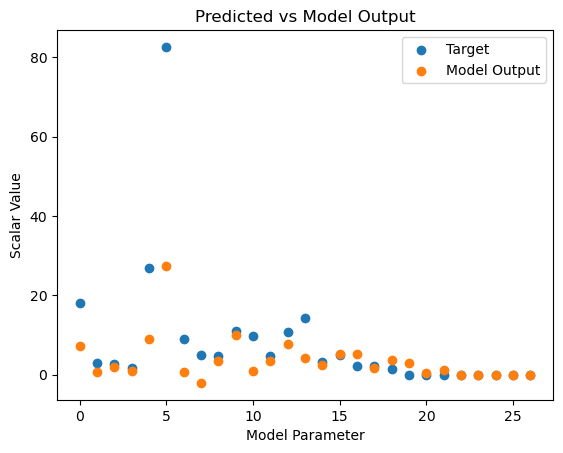

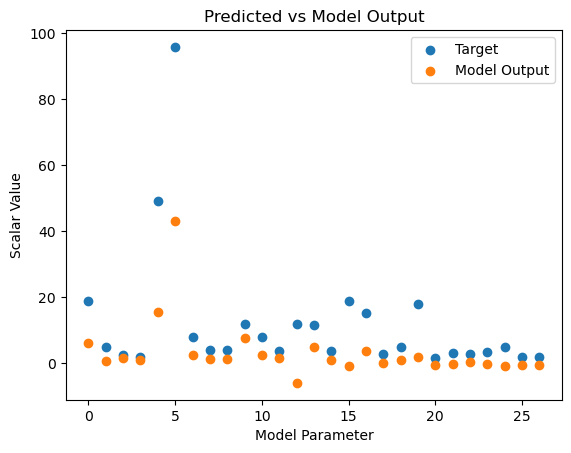

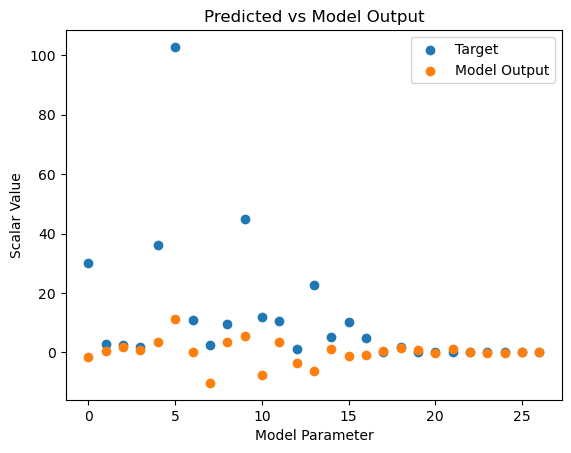

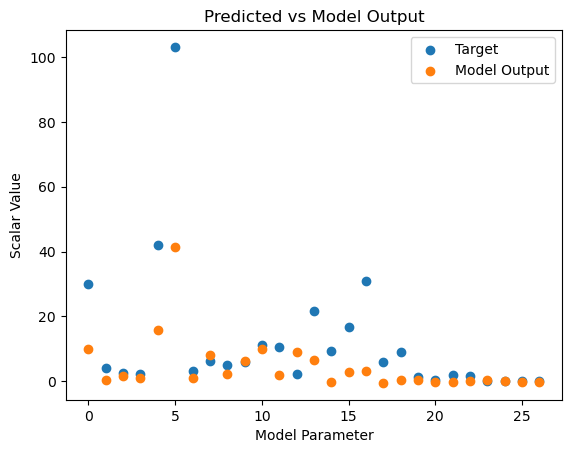

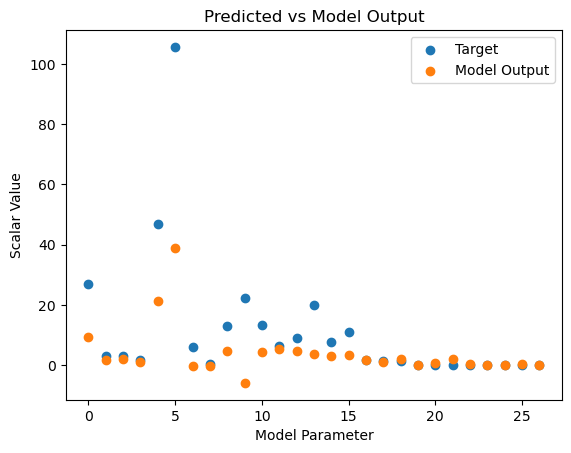

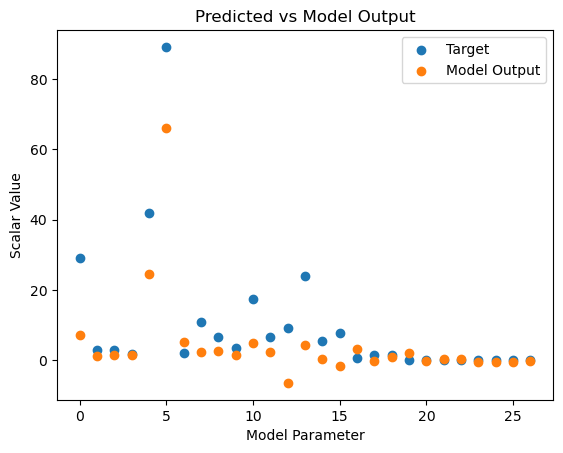

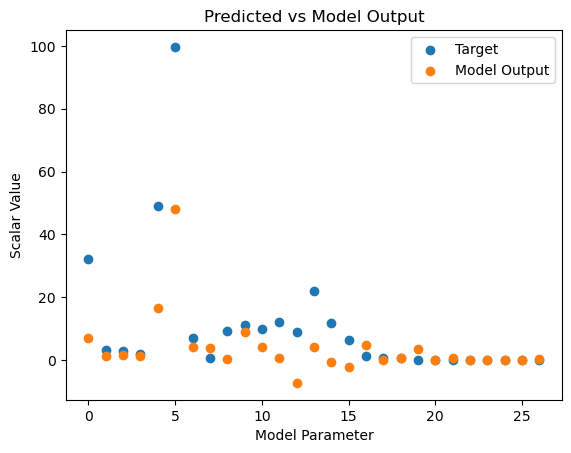

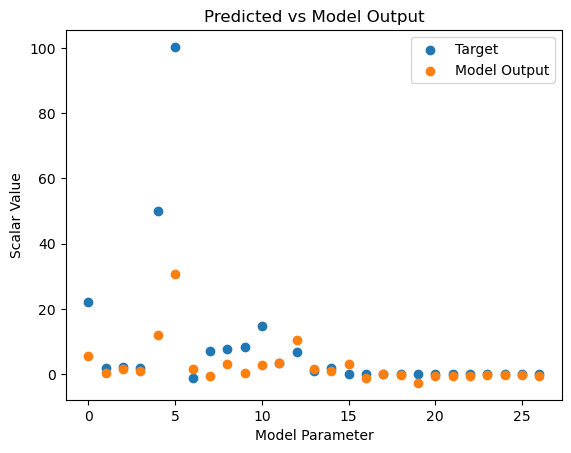

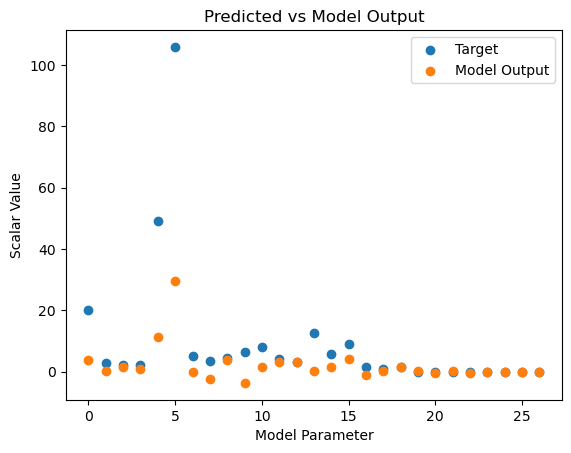

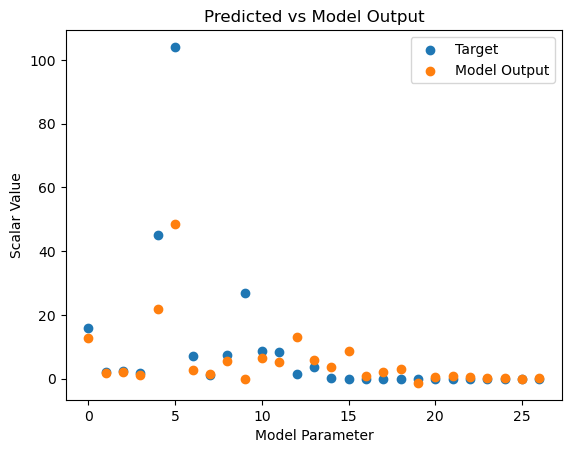

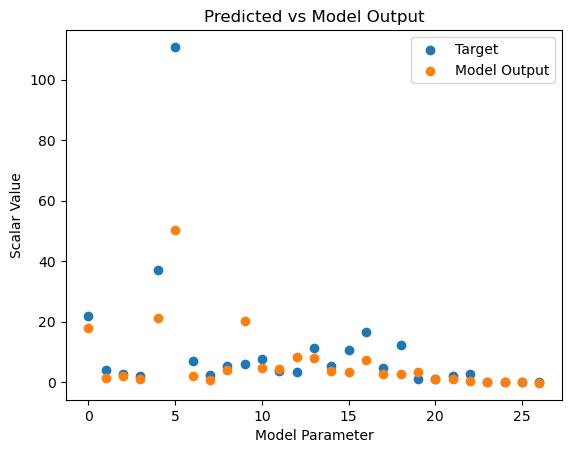

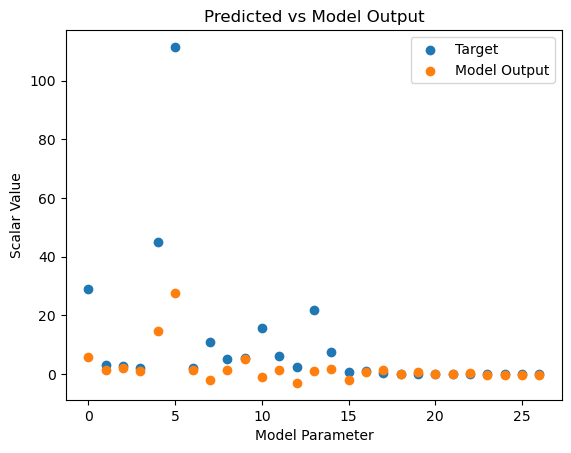

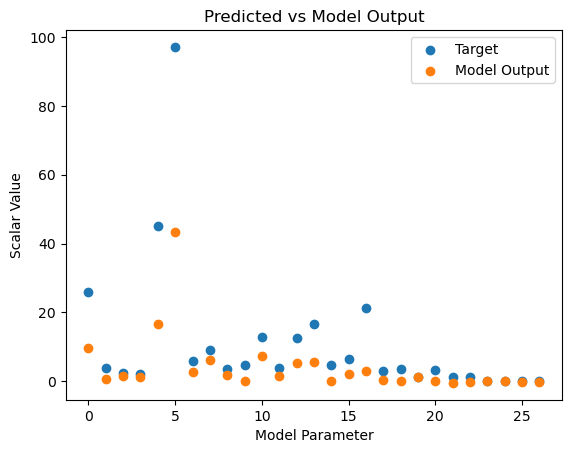

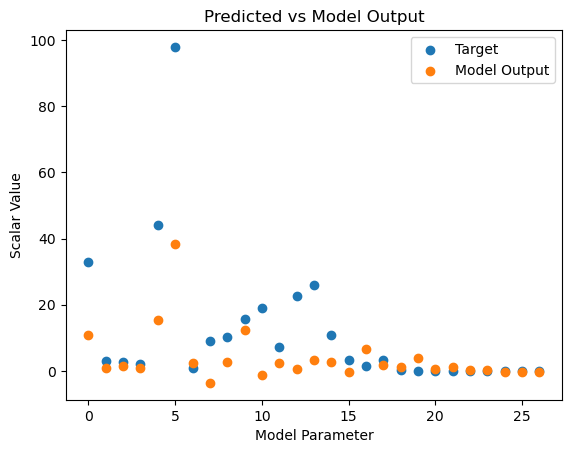

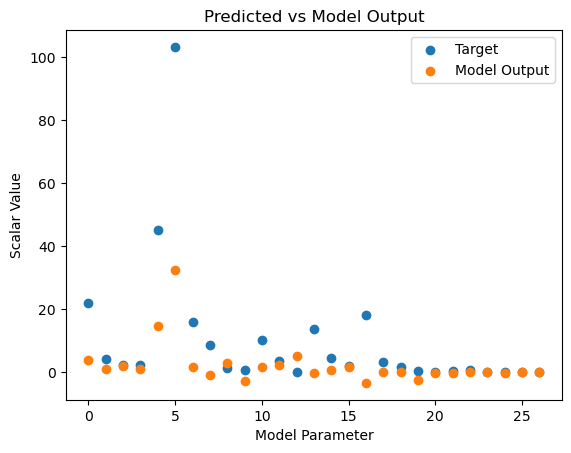

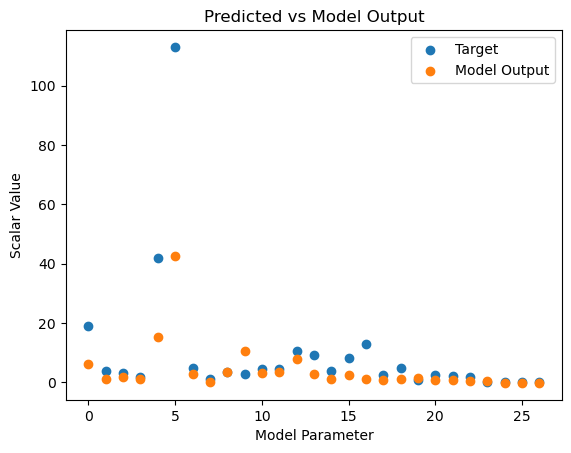

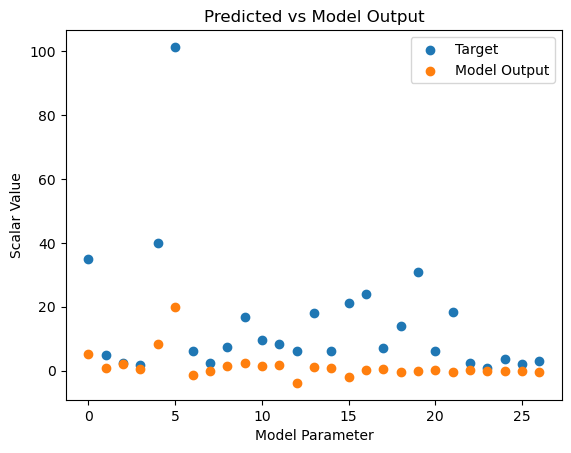

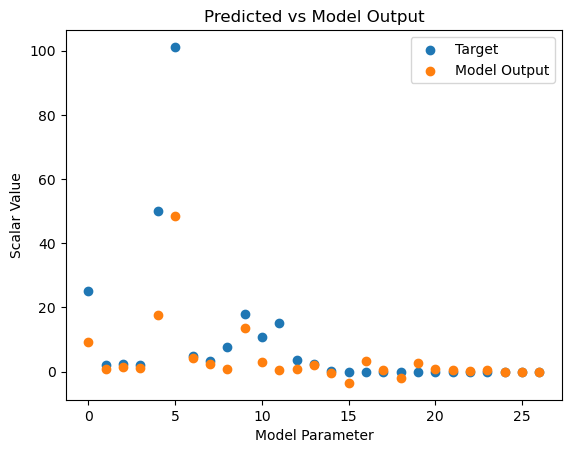

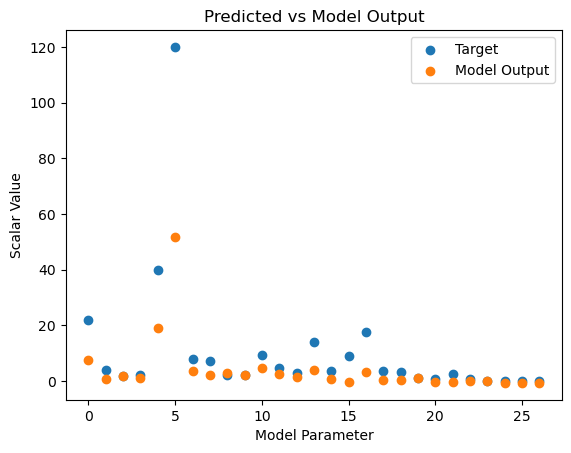

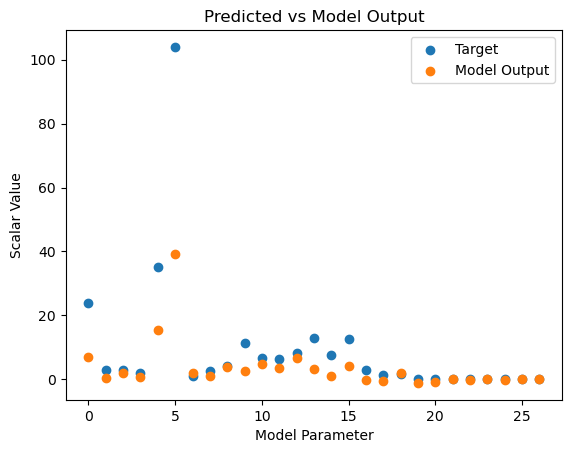

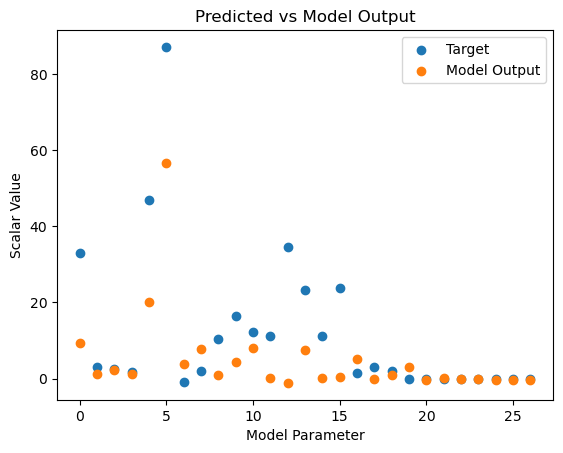

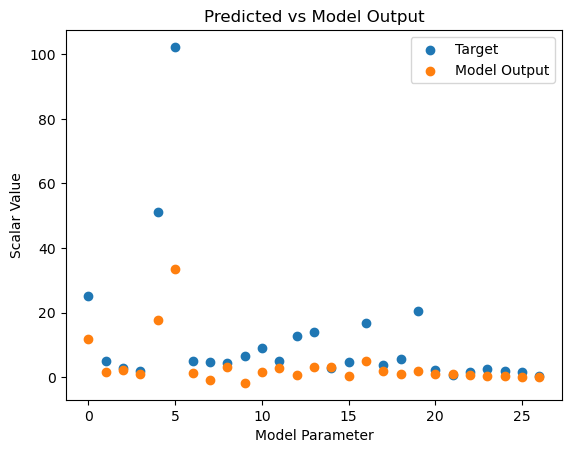

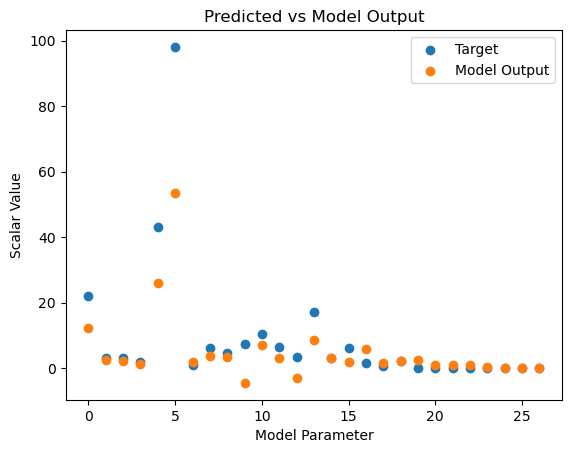

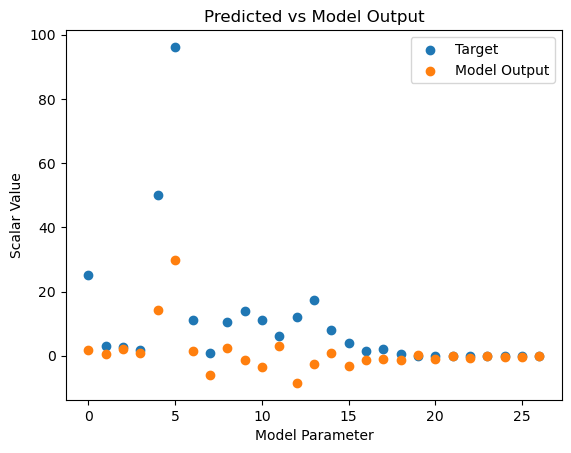

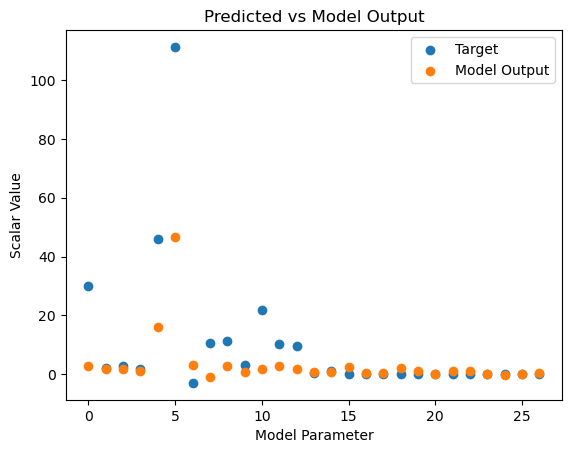

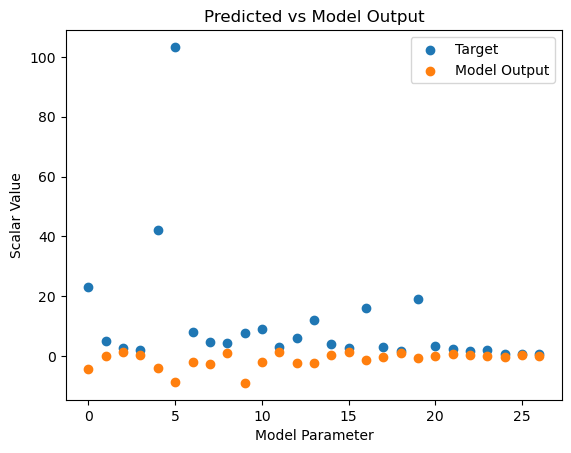

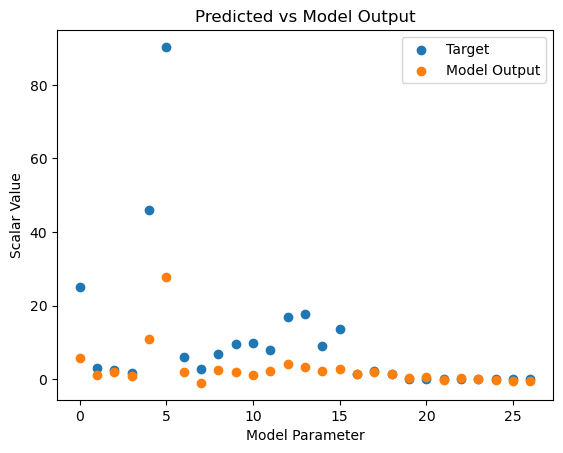

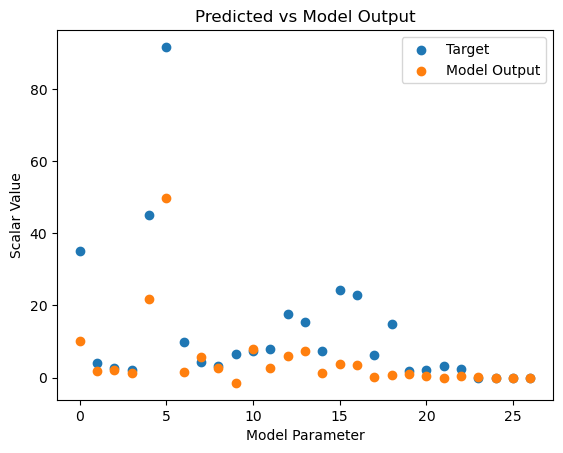

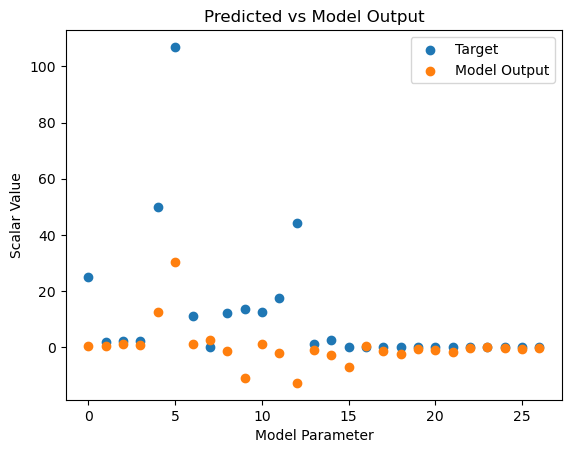

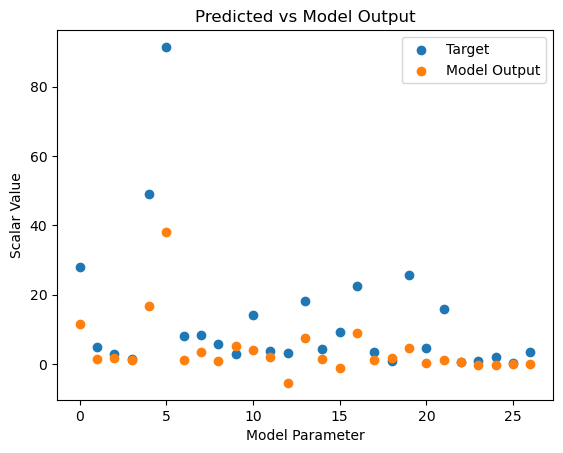

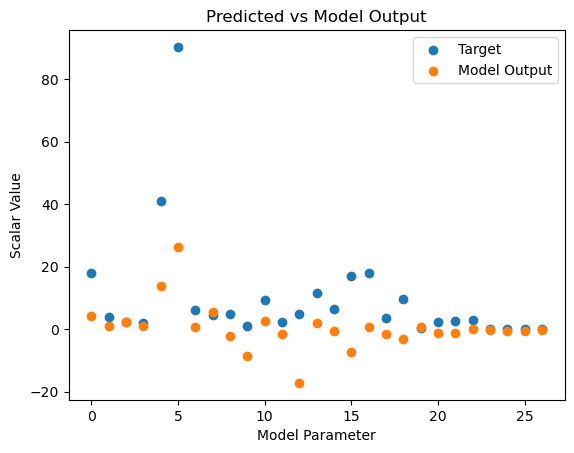

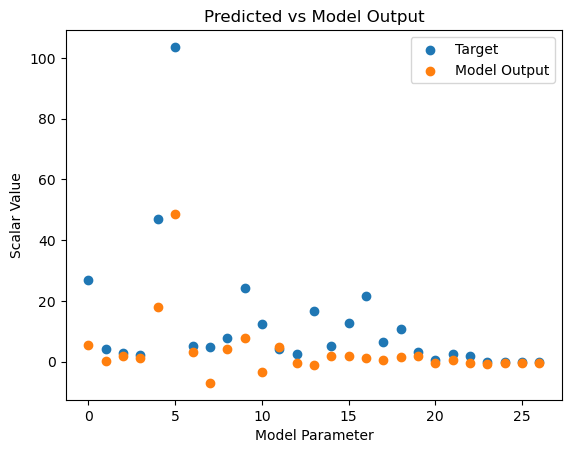

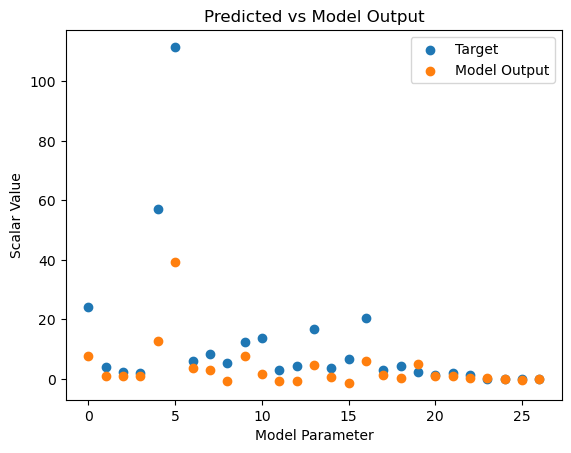

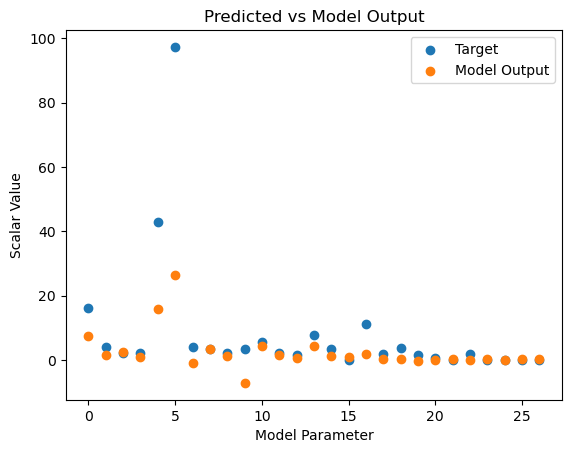

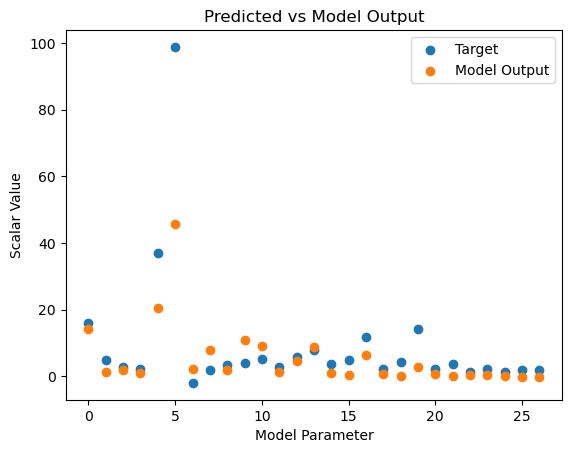

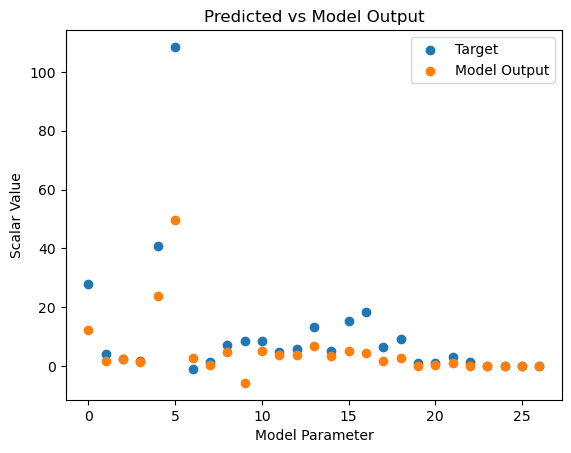

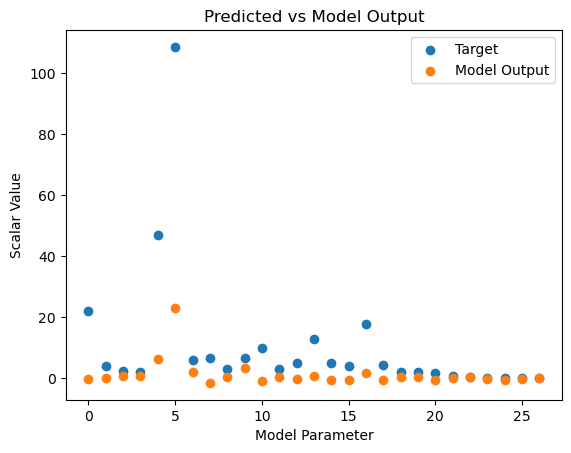

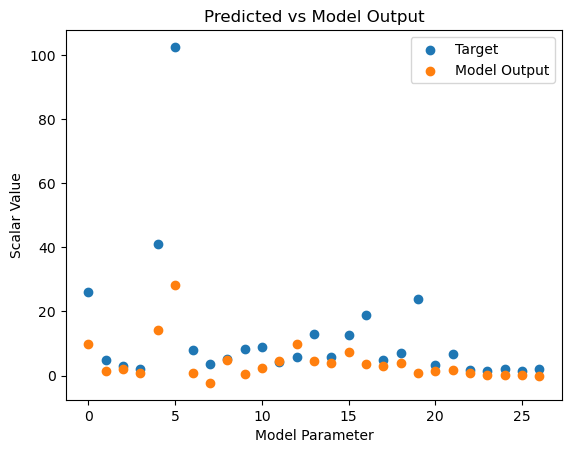

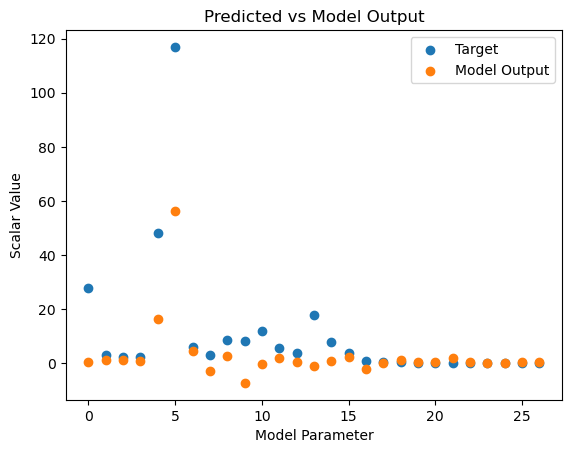

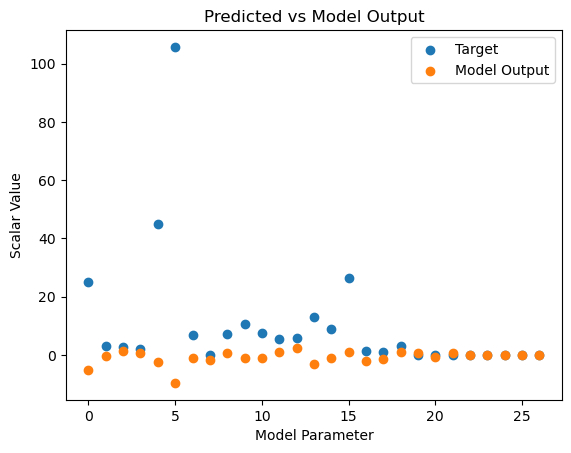

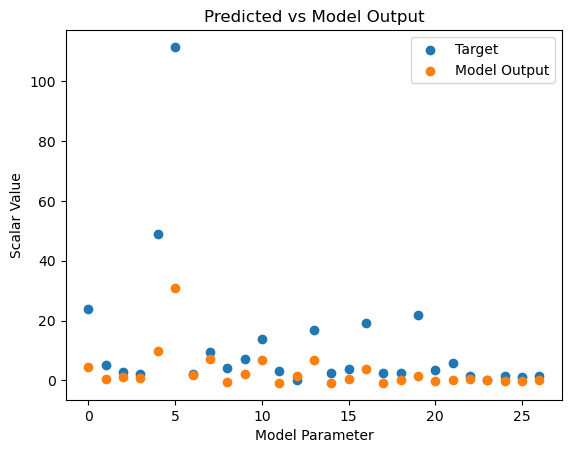

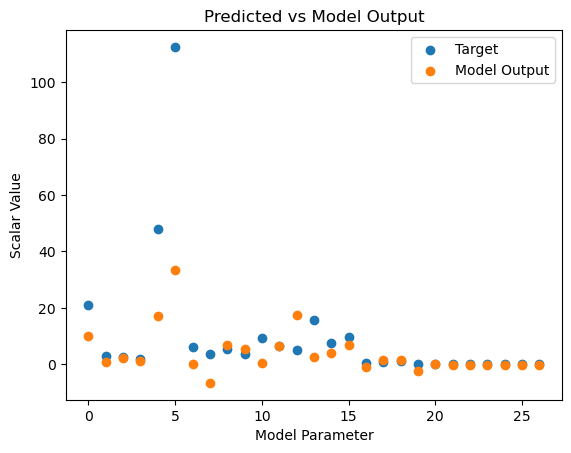

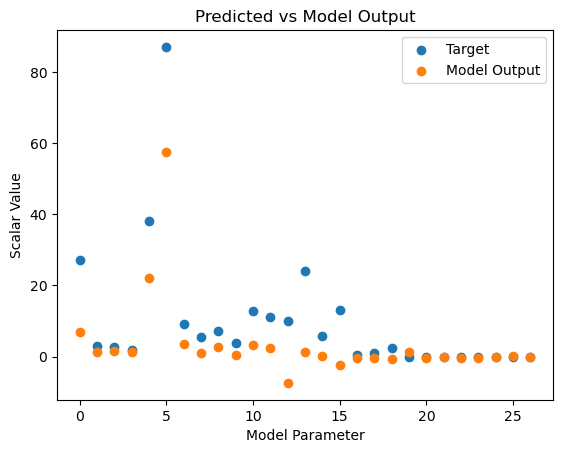

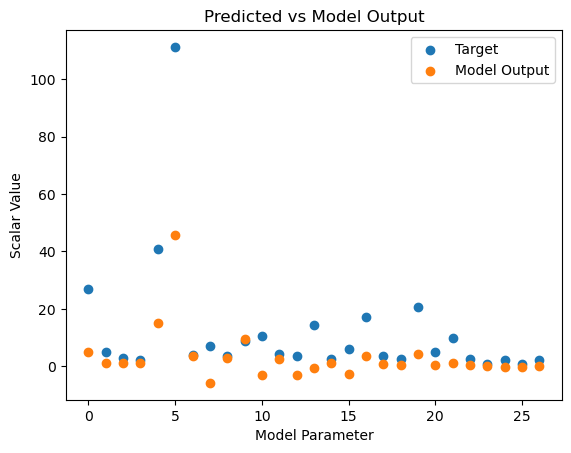

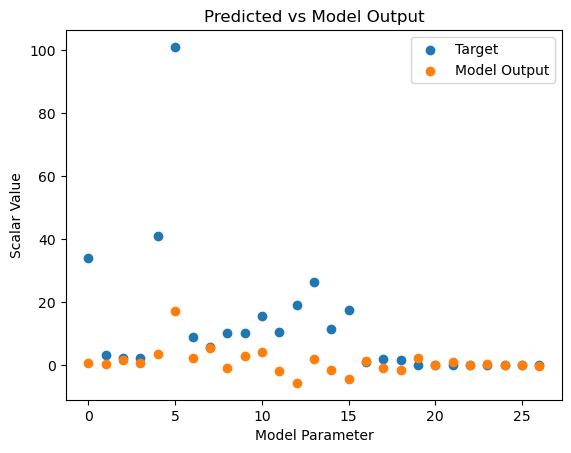

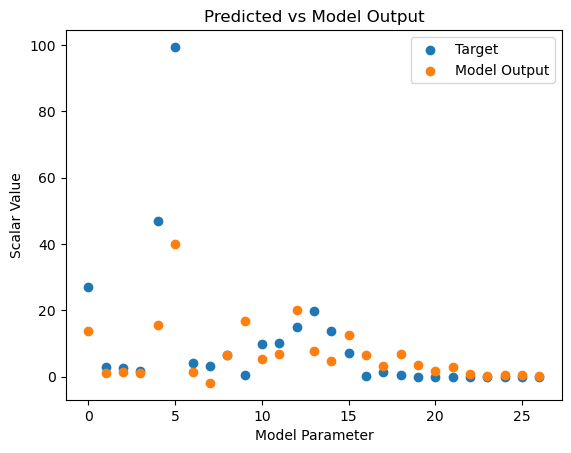

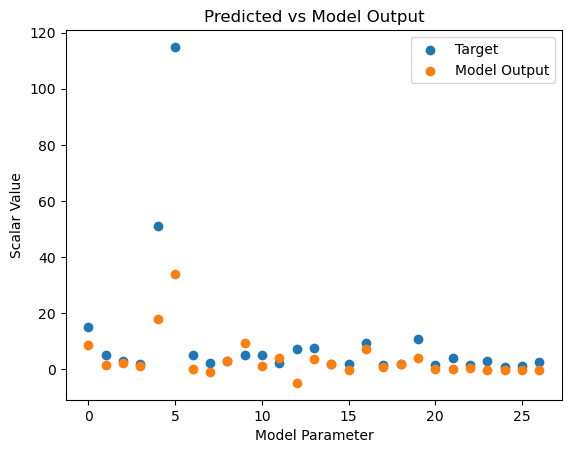

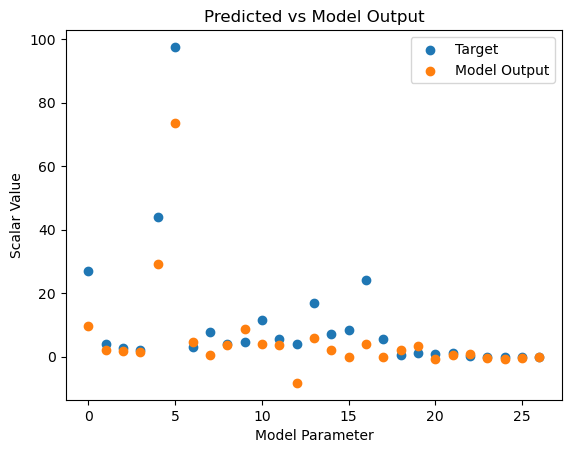

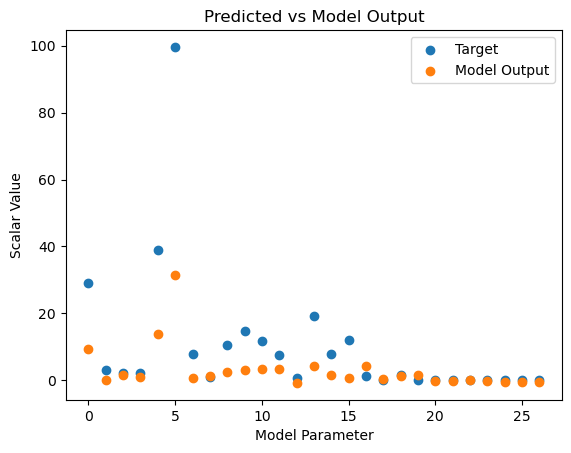

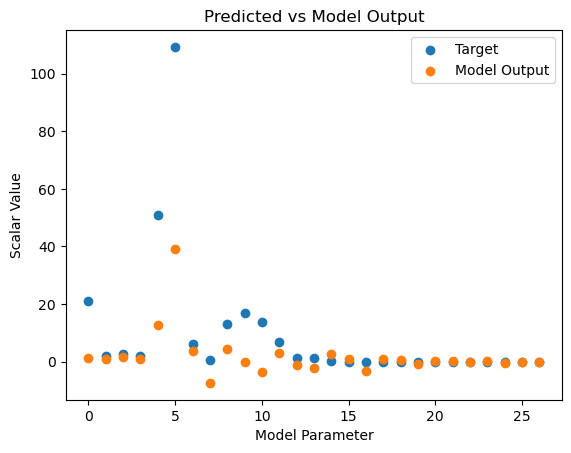

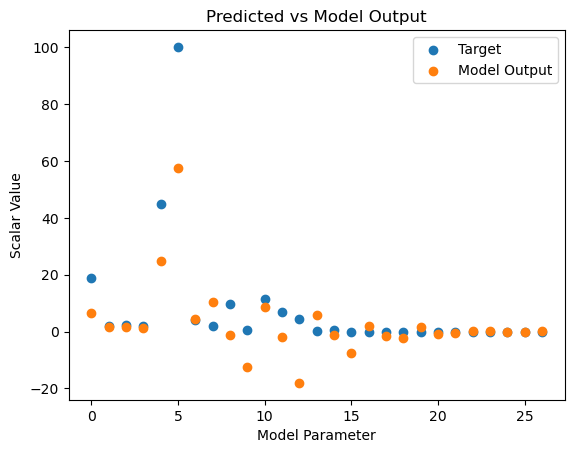

In [56]:
show_many(checkpoints[0])
#show_many(checkpoints[0])
#show_many(checkpoints[0])

In [35]:
model.

Transformer(
  (_embeddingLayer): Linear(in_features=4, out_features=64, bias=True)
  (_out1): Linear(in_features=64, out_features=27, bias=True)
)